# SAR Image Quality Assessment Performance Evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score, mean_absolute_error
import cv2
import os

C:\Users\SZEERN\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Ground-truth assessment

In paper, Section 3.2.3.1

In [2]:
# Function to read an image
def read_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Variance calculation for masked areas
def calculate_variance(groundtruth_image, inpainted_image, mask):
     # Convert images to grayscale
    groundtruth_gray = cv2.cvtColor(groundtruth_image, cv2.COLOR_BGR2GRAY)
    inpainted_gray = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)
    
    # Correctly apply the mask
    groundtruth_gray_masked = cv2.bitwise_and(groundtruth_gray, groundtruth_gray, mask=mask)
    inpainted_gray_masked = cv2.bitwise_and(inpainted_gray, inpainted_gray, mask=mask)
    
    # Calculate the absolute difference between the masked images
    compare_masked = np.stack([groundtruth_gray_masked, inpainted_gray_masked])
    
    # Calculate and return the variance of the normalized differences within the masked area
    #return np.var(normalized_difference_masked[normalized_difference_masked > 0])
    return np.mean(np.var(compare_masked,axis=0))
    
def calculate_metrics(groundtruth_image, inpainted_image, mask):
    groundtruth_gray = cv2.cvtColor(groundtruth_image, cv2.COLOR_BGR2GRAY)
    inpainted_gray = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)
    
    # Correctly apply the mask
    groundtruth_gray_masked = cv2.bitwise_and(groundtruth_gray, groundtruth_gray, mask=mask)
    inpainted_gray_masked = cv2.bitwise_and(inpainted_gray, inpainted_gray, mask=mask)
    
    r2 = r2_score(groundtruth_gray_masked, inpainted_gray_masked)
    mae = mean_absolute_error(groundtruth_gray_masked, inpainted_gray_masked)
    
    return r2, mae

# Perform comparisons and visualizations
def compare_and_visualize(org_path, inpainted_path, mask_path, gt_path):
    org = read_image(org_path)
    inpainted = read_image(inpainted_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt = read_image(gt_path)
    
    ssim_score = calculate_ssim(gt, inpainted, mask)
    variance_score = calculate_variance(gt, inpainted, mask)
    
    print(f"SSIM: {ssim_score}")
    print(f"Normalized Variance: {variance_score}")



#SINGLE IMAGE PROCESSING
#compare_images('./ORG_DIP_2019/00001.png', './INPAINTED_DIP_2019/00001.png', './ANNOTATIONS_DIP_2019/00001.jpg', './GROUNDTRUTH_DIP_2019/00001.jpg')



Average R2 (DSTT): 0.899
Average MAE (DSTT): 6.380
Average R2 (DIP): 0.941
Average MAE (DIP): 6.397
Average R2 (2019 DSTT): 0.967
Average MAE (2019 DSTT): 9.649
Average R2 (2019 DIP): 0.986
Average MAE (2019 DIP): 9.963
Average R2 (2021 DSTT): 0.837
Average MAE (2021 DSTT): 3.370
Average R2 (2021 DIP): 0.900
Average MAE (2021 DIP): 3.112


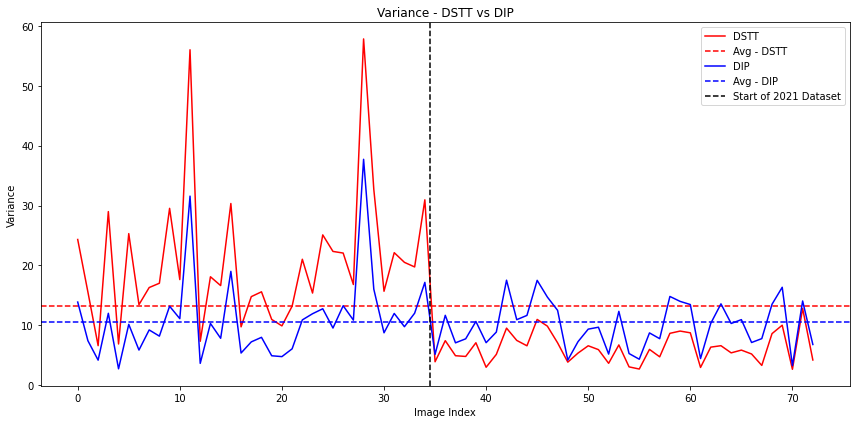

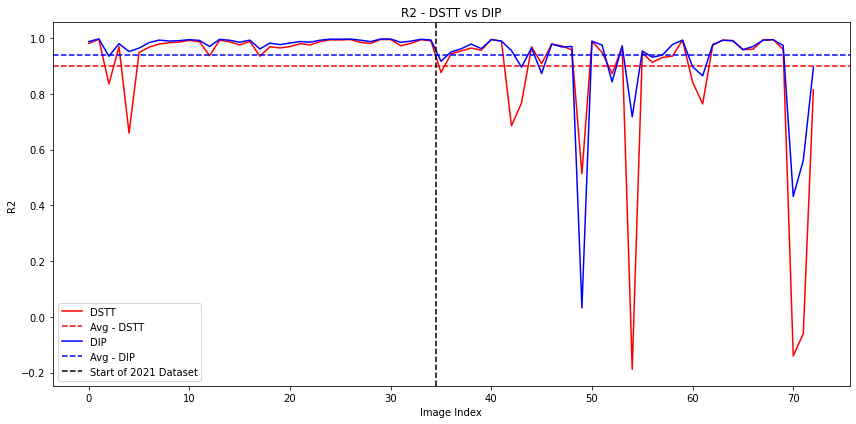

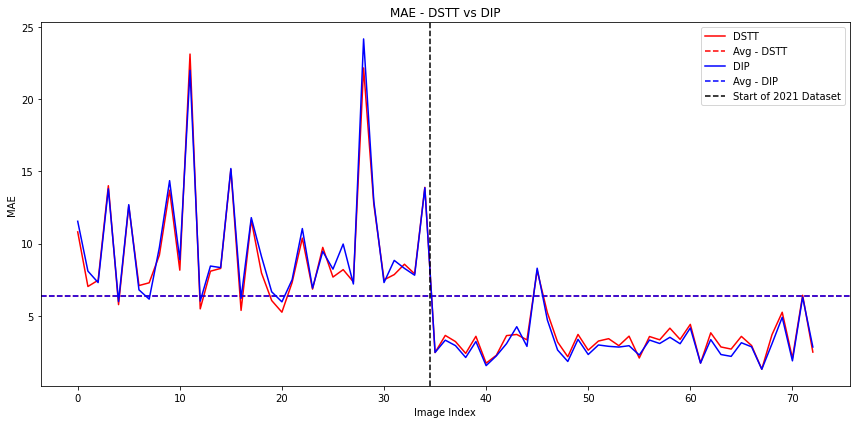

In [3]:
# Function to automatically find the file extension for a given index in a directory
def find_extension(directory, index):
    for extension in ['.jpg', '.png']:
        if os.path.exists(os.path.join(directory, f"{index}{extension}")):
            return extension
    raise FileNotFoundError(f"No file found for index {index} in {directory} with supported extensions.")

# Batch processing function
def batch_process_images(org_dir, inpainted_dir, mask_dir, gt_dir):
    variance_scores = []
    r2_scores = []  
    mae_scores = []
    image_indices = sorted({fname.split('.')[0] for fname in os.listdir(org_dir)})  # Assuming all dirs have same indices

    for index in image_indices:
        try:
            org_ext = find_extension(org_dir, index)
            inpainted_ext = find_extension(inpainted_dir, index)
            mask_ext = find_extension(mask_dir, index)
            gt_ext = find_extension(gt_dir, index)

            org_path = os.path.join(org_dir, f"{index}{org_ext}")
            inpainted_path = os.path.join(inpainted_dir, f"{index}{inpainted_ext}")
            mask_path = os.path.join(mask_dir, f"{index}{mask_ext}")
            gt_path = os.path.join(gt_dir, f"{index}{gt_ext}")

            org = read_image(org_path)
            inpainted = read_image(inpainted_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            gt = read_image(gt_path)

            variance_score = calculate_variance(gt, inpainted, mask)
            r2_score, mae_score = calculate_metrics(gt, inpainted, mask)

            variance_scores.append(variance_score)
            r2_scores.append(r2_score)
            mae_scores.append(mae_score) 
        
        except FileNotFoundError as e:
            print(e)
            continue

    return variance_scores, r2_scores, mae_scores


# Plotting the results
def plot_combined_metrics(metric_list_1, metric_list_2, metric_list_1_1, metric_name):
    plt.figure(figsize=(12, 6))
    
    combined_length = len(metric_list_1_1)

    plt.plot(metric_list_1, label='DSTT', color='red')
    plt.axhline(y=np.mean([score for score in metric_list_1 if score is not None]), color='r', linestyle='--', label='Avg - DSTT')
    
    plt.plot(metric_list_2, label='DIP', color='blue')
    plt.axhline(y=np.mean([score for score in metric_list_2 if score is not None]), color='b', linestyle='--', label='Avg - DIP')
    
    plt.axvline(x=combined_length - 0.5, color='k', linestyle='--', label='Start of 2021 Dataset')
    
    plt.xlabel('Image Index')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} - DSTT vs DIP')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
# File assignment
org_dir_1 = './ORG_DSTT_2019'
inpainted_dir_1 = './INPAINTED_DSTT_2019'
mask_dir_1 = './ANNOTATIONS_DSTT_2019'
gt_dir_1 = './GROUNDTRUTH_DSTT_2019'

org_dir_2 = './ORG_DSTT_2021'
inpainted_dir_2 = './INPAINTED_DSTT_2021'
mask_dir_2 = './ANNOTATIONS_DSTT_2021'
gt_dir_2 = './GROUNDTRUTH_DSTT_2021'

org_dir_3 = './ORG_DIP_2019'
inpainted_dir_3 = './INPAINTED_DIP_2019'
mask_dir_3 = './ANNOTATIONS_DIP_2019'
gt_dir_3 = './GROUNDTRUTH_DIP_2019'

org_dir_4 = './ORG_DIP_2021'
inpainted_dir_4 = './INPAINTED_DIP_2021'
mask_dir_4 = './ANNOTATIONS_DIP_2021'
gt_dir_4 = './GROUNDTRUTH_DIP_2021'

variance_scores_1, r2_scores_1, mae_scores_1  = batch_process_images(org_dir_1, inpainted_dir_1, mask_dir_1, gt_dir_1)
variance_scores_2, r2_scores_2, mae_scores_2 = batch_process_images(org_dir_2, inpainted_dir_2, mask_dir_2, gt_dir_2)
variance_scores_3, r2_scores_3, mae_scores_3 = batch_process_images(org_dir_3, inpainted_dir_3, mask_dir_3, gt_dir_3)
variance_scores_4, r2_scores_4, mae_scores_4 = batch_process_images(org_dir_4, inpainted_dir_4, mask_dir_4, gt_dir_4)

#Combine datasets
variance_scores_DSTT = variance_scores_1 + variance_scores_2
variance_scores_DIP = variance_scores_3 + variance_scores_4
r2_scores_DSTT = r2_scores_1 + r2_scores_2
r2_scores_DIP = r2_scores_3 + r2_scores_4
mae_scores_DSTT = mae_scores_1 + mae_scores_2
mae_scores_DIP = mae_scores_3 + mae_scores_4

avg_r2_DSTT = np.mean([score for score in r2_scores_DSTT if score is not None])
avg_mae_DSTT = np.mean([score for score in mae_scores_DSTT if score is not None])

avg_r2_DIP = np.mean([score for score in r2_scores_DIP if score is not None])
avg_mae_DIP = np.mean([score for score in mae_scores_DIP if score is not None])

avg_r2_DSTT_2019 = np.mean([score for score in r2_scores_1 if score is not None])
avg_mae_DSTT_2019 = np.mean([score for score in mae_scores_1 if score is not None])

avg_r2_DIP_2019 = np.mean([score for score in r2_scores_3 if score is not None])
avg_mae_DIP_2019 = np.mean([score for score in mae_scores_3 if score is not None])

avg_r2_DSTT_2021 = np.mean([score for score in r2_scores_2 if score is not None])
avg_mae_DSTT_2021 = np.mean([score for score in mae_scores_2 if score is not None])

avg_r2_DIP_2021 = np.mean([score for score in r2_scores_4 if score is not None])
avg_mae_DIP_2021 = np.mean([score for score in mae_scores_4 if score is not None])


print(f"Average R2 (DSTT): {avg_r2_DSTT:.3f}")
print(f"Average MAE (DSTT): {avg_mae_DSTT:.3f}")

print(f"Average R2 (DIP): {avg_r2_DIP:.3f}")
print(f"Average MAE (DIP): {avg_mae_DIP:.3f}")

print(f"Average R2 (2019 DSTT): {avg_r2_DSTT_2019:.3f}")
print(f"Average MAE (2019 DSTT): {avg_mae_DSTT_2019:.3f}")

print(f"Average R2 (2019 DIP): {avg_r2_DIP_2019:.3f}")
print(f"Average MAE (2019 DIP): {avg_mae_DIP_2019:.3f}")

print(f"Average R2 (2021 DSTT): {avg_r2_DSTT_2021:.3f}")
print(f"Average MAE (2021 DSTT): {avg_mae_DSTT_2021:.3f}")

print(f"Average R2 (2021 DIP): {avg_r2_DIP_2021:.3f}")
print(f"Average MAE (2021 DIP): {avg_mae_DIP_2021:.3f}")

plot_combined_metrics(variance_scores_DSTT, variance_scores_DIP, variance_scores_1,'Variance')
plot_combined_metrics(r2_scores_DSTT, r2_scores_DIP, r2_scores_1,'R2')
plot_combined_metrics(mae_scores_DSTT, mae_scores_DIP, mae_scores_1,'MAE')




# Obstacle Coverage Percentage

In [4]:
def get_mask_coverage(mask):
    total_pixels = mask.shape[0] * mask.shape[1]
    masked_pixels = np.count_nonzero(mask)
    coverage_percentage = (masked_pixels / total_pixels) * 100
    return coverage_percentage

def coverage_percentage(mask_folder):
    
    coverage_list = []
    mask_img_list = os.listdir(mask_folder)
    
    for i in range(len(mask_img_list)):
        
        mask_img = cv2.imread(os.path.join(mask_folder, mask_img_list[i]), cv2.IMREAD_GRAYSCALE)
        coverage_percentage = get_mask_coverage(mask_img)
        coverage_list.append(coverage_percentage)
    
    return coverage_list

def Average_coverage(coverage_list):
    total_coverage = sum(coverage for coverage in coverage_list)
    mean_coverage = total_coverage / len(coverage_list)
    min_coverage = min(coverage_list)
    max_coverage = max(coverage_list)
    
    print(f"Average Coverage Percentage: {mean_coverage}")
    print(f"Minimum Coverage Percentage: {min_coverage}")
    print(f"Maximum Coverage Percentage: {max_coverage}")
    
def Average_var (variance_list):
    total_var = sum(var for var in variance_list)
    mean_var = total_var / len(variance_list)
    print(f"Average VAR score: {mean_var}")
    
def plot_correlation(coverage_list_1, coverage_list_2, variance_list_1, variance_list_2, label):
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    
    ax[0].plot(coverage_list_1, c='r',label='DSTT')
    ax[0].plot(coverage_list_2, c='b',label='DIP')
    ax[0].legend()
    ax[0].set_ylabel("Coverage Percentage")
    ax[0].set_xlabel("Image Index")
    ax[0].set_title("Coverage Percentage (DSTT vs DIP)")
    
    ax[1].plot([var for var in variance_list_1], c='r',label='DSTT')
    ax[1].plot([var for var in variance_list_2], c='b',label='DIP')
    ax[1].legend()
    ax[1].set_ylabel(f"{label}")
    ax[1].set_xlabel("Image Index")
    ax[1].set_title(f"{label} (DSTT vs DIP)")
    
    Average_var(variance_list_1)
    Average_var(variance_list_2)
    Average_coverage(coverage_list_1)
    Average_coverage(coverage_list_2)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    
    # Scatterplot with best fit line for DSTT
    ax[0].scatter(coverage_list_1, [var.mean() for var in variance_list_1], label=label)
    ax[0].set_xlabel("Coverage Percentage")
    ax[0].set_ylabel(f"{label}")
    ax[0].set_title(f"{label} (DSTT) vs Coverage Percentage")
    ax[0].legend()

    # Perform linear regression for DSTT
    m1, b1 = np.polyfit(coverage_list_1, [var.mean() for var in variance_list_1], 1)
    ax[0].plot(coverage_list_1, m1 * np.array(coverage_list_1) + b1, color='black', linestyle='--', label='Best Fit Line (DSTT)')

    correlation_coefficient_line1 = compute_correlation_coefficient([var.mean() for var in variance_list_1], coverage_list_1)
    print(f"Correlation Coefficient ({label} vs Coverage Percentage) DSTT: {correlation_coefficient_line1}")

    # Scatterplot with best fit line for DIP
    ax[1].scatter(coverage_list_2, [var.mean() for var in variance_list_2], label=label)
    ax[1].set_xlabel("Coverage Percentage")
    ax[1].set_ylabel(f"{label}")
    ax[1].set_title(f"{label} (DIP) vs Coverage Percentage")
    ax[1].legend()

    # Perform linear regression for DIP
    m2, b2 = np.polyfit(coverage_list_2, [var.mean() for var in variance_list_2], 1)
    ax[1].plot(coverage_list_2, m2 * np.array(coverage_list_2) + b2, color='black', linestyle='--', label='Best Fit Line (DIP)')

    correlation_coefficient_line10 = compute_correlation_coefficient([var.mean() for var in variance_list_2], coverage_list_2)
    print(f"Correlation Coefficient ({label}vs Coverage Percentage) DIP: {correlation_coefficient_line10}")

    plt.show()
    
    

def compute_correlation_coefficient(x, y):
    correlation_matrix = np.corrcoef(x, y)
    correlation_coefficient = correlation_matrix[0, 1]
    return correlation_coefficient

def filter_none_values(coverage_list, metric_list):
    filtered_coverage = []
    filtered_metric = []
    for coverage, metric in zip(coverage_list, metric_list):
        if metric is not None and coverage is not None:
            filtered_coverage.append(coverage)
            filtered_metric.append(metric)
    return filtered_coverage, filtered_metric


def plot_correlation_r2mae(coverage_list_DSTT, coverage_list_DIP, r2_list_DSTT, r2_list_DIP, mae_list_DSTT, mae_list_DIP):
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))

    # Filter out None values for DSTT R2
    filtered_coverage_DSTT_r2, filtered_r2_DSTT = filter_none_values(coverage_list_DSTT, r2_list_DSTT)
    # Filter out None values for DIP R2
    filtered_coverage_DIP_r2, filtered_r2_DIP = filter_none_values(coverage_list_DIP, r2_list_DIP)
    # Filter out None values for DSTT MAE
    filtered_coverage_DSTT_mae, filtered_mae_DSTT = filter_none_values(coverage_list_DSTT, mae_list_DSTT)
    # Filter out None values for DIP MAE
    filtered_coverage_DIP_mae, filtered_mae_DIP = filter_none_values(coverage_list_DIP, mae_list_DIP)
    
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))  # Adjust for 4 subplots
    
    # R2 Score Correlation for DSTT
    axs[0, 0].scatter(filtered_coverage_DSTT_r2,  filtered_r2_DSTT, label='R2 Score', color='r')
    axs[0, 0].set_xlabel("Coverage Percentage")
    axs[0, 0].set_ylabel("R2 Score")
    axs[0, 0].set_title("R2 Score (DSTT) vs Coverage Percentage")
    axs[0, 0].legend()
    # Linear regression for DSTT R2
    m1, b1 = np.polyfit(filtered_coverage_DSTT_r2,filtered_r2_DSTT, 1)
    axs[0, 0].plot(filtered_coverage_DSTT_r2, m1 * np.array(filtered_coverage_DSTT_r2) + b1, color='black', linestyle='--', label='Best Fit Line (DSTT)')
    correlation_coefficient_R2_DSTT = compute_correlation_coefficient(filtered_r2_DSTT,filtered_coverage_DSTT_r2)
    print(f"Correlation Coefficient (R2 Score (DSTT) vs Coverage Percentage): {correlation_coefficient_R2_DSTT}")

    
    # R2 Score Correlation for DIP
    axs[0, 1].scatter(filtered_coverage_DIP_r2, filtered_r2_DIP, label='R2 Score', color='b')
    axs[0, 1].set_xlabel("Coverage Percentage")
    axs[0, 1].set_ylabel("R2 Score")
    axs[0, 1].set_title("R2 Score (DIP) vs Coverage Percentage")
    axs[0, 1].legend()
    # Linear regression for DIP R2
    m2, b2 = np.polyfit(filtered_coverage_DIP_r2, filtered_r2_DIP, 1)
    axs[0, 1].plot(filtered_coverage_DIP_r2, m2 * np.array(filtered_coverage_DIP_r2) + b2, color='black', linestyle='--', label='Best Fit Line (DIP)')
    correlation_coefficient_R2_DIP = compute_correlation_coefficient(filtered_r2_DIP,filtered_coverage_DIP_r2)
    print(f"Correlation Coefficient (R2 Score (DIP) vs Coverage Percentage): {correlation_coefficient_R2_DIP}")
    
    # MAE Correlation for DSTT
    axs[1, 0].scatter(filtered_coverage_DSTT_mae, filtered_mae_DSTT, label='MAE', color='r')
    axs[1, 0].set_xlabel("Coverage Percentage")
    axs[1, 0].set_ylabel("MAE")
    axs[1, 0].set_title("MAE (DSTT) vs Coverage Percentage")
    axs[1, 0].legend()
    # Linear regression for DSTT MAE
    m3, b3 = np.polyfit(filtered_coverage_DSTT_mae, filtered_mae_DSTT, 1)
    axs[1, 0].plot(filtered_coverage_DSTT_mae, m3 * np.array(filtered_coverage_DSTT_mae) + b3, color='black', linestyle='--', label='Best Fit Line (DSTT)')
    correlation_coefficient_mae_DSTT = compute_correlation_coefficient(filtered_mae_DSTT,filtered_coverage_DSTT_mae)
    print(f"Correlation Coefficient (MAE (DSTT) vs Coverage Percentage): {correlation_coefficient_mae_DSTT}")
    
    # MAE Correlation for DIP
    axs[1, 1].scatter(filtered_coverage_DIP_mae, filtered_mae_DIP, label='MAE', color='b')
    axs[1, 1].set_xlabel("Coverage Percentage")
    axs[1, 1].set_ylabel("MAE")
    axs[1, 1].set_title("MAE (DIP) vs Coverage Percentage")
    axs[1, 1].legend()
    # Linear regression for DIP MAE
    m4, b4 = np.polyfit(filtered_coverage_DIP_mae, filtered_mae_DIP, 1)
    axs[1, 1].plot(filtered_coverage_DIP_mae, m4 * np.array(filtered_coverage_DIP_mae) + b4, color='black', linestyle='--', label='Best Fit Line (DIP)')
    correlation_coefficient_mae_DIP = compute_correlation_coefficient(filtered_mae_DIP,filtered_coverage_DIP_mae)
    print(f"Correlation Coefficient (MAE (DIP) vs Coverage Percentage): {correlation_coefficient_mae_DIP}")
    
    plt.tight_layout()
    plt.show()
    

In [5]:
coverage_list_1 = coverage_percentage('ANNOTATIONS_DSTT_2019')
coverage_list_2 = coverage_percentage('ANNOTATIONS_DSTT_2021')
coverage_list_3 = coverage_percentage('ANNOTATIONS_DIP_2019')
coverage_list_4 = coverage_percentage('ANNOTATIONS_DIP_2021')

DSTT_list_coverage = coverage_list_1 + coverage_list_2
DIP_list_coverage = coverage_list_3 + coverage_list_4


Average VAR score: 13.171448437235748
Average VAR score: 10.484613228217498
Average Coverage Percentage: 4.995151044309147
Minimum Coverage Percentage: 0.9789737654320988
Maximum Coverage Percentage: 17.814429012345677
Average Coverage Percentage: 5.122235143254646
Minimum Coverage Percentage: 1.1274065290178572
Maximum Coverage Percentage: 18.627057756696427
Correlation Coefficient (Variance vs Coverage Percentage) DSTT: 0.9660167133625798
Correlation Coefficient (Variancevs Coverage Percentage) DIP: 0.6226488372953405


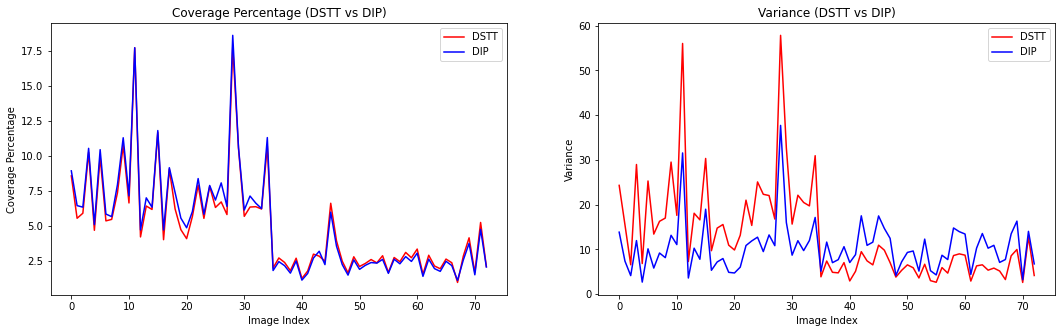

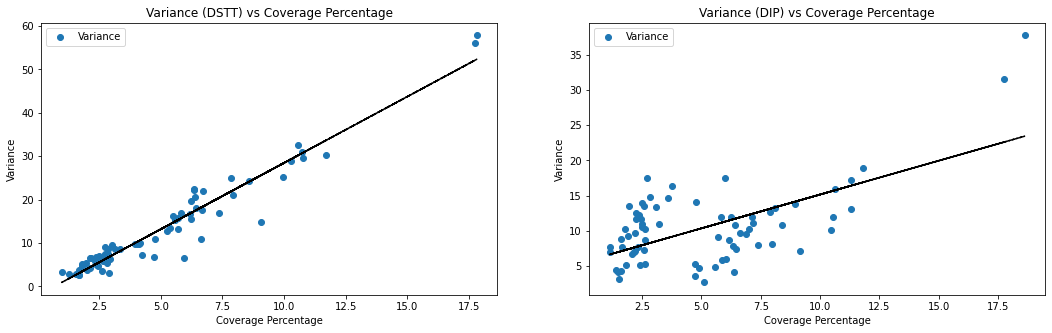

Correlation Coefficient (R2 Score (DSTT) vs Coverage Percentage): 0.18615335195985208
Correlation Coefficient (R2 Score (DIP) vs Coverage Percentage): 0.21415192233570643
Correlation Coefficient (MAE (DSTT) vs Coverage Percentage): 0.9984466263274975
Correlation Coefficient (MAE (DIP) vs Coverage Percentage): 0.21415192233570643


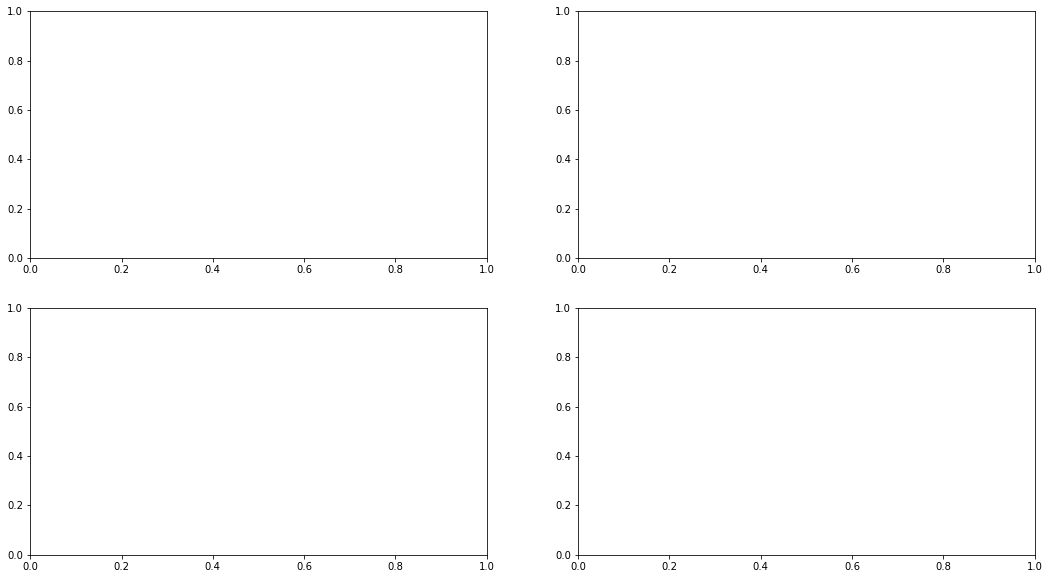

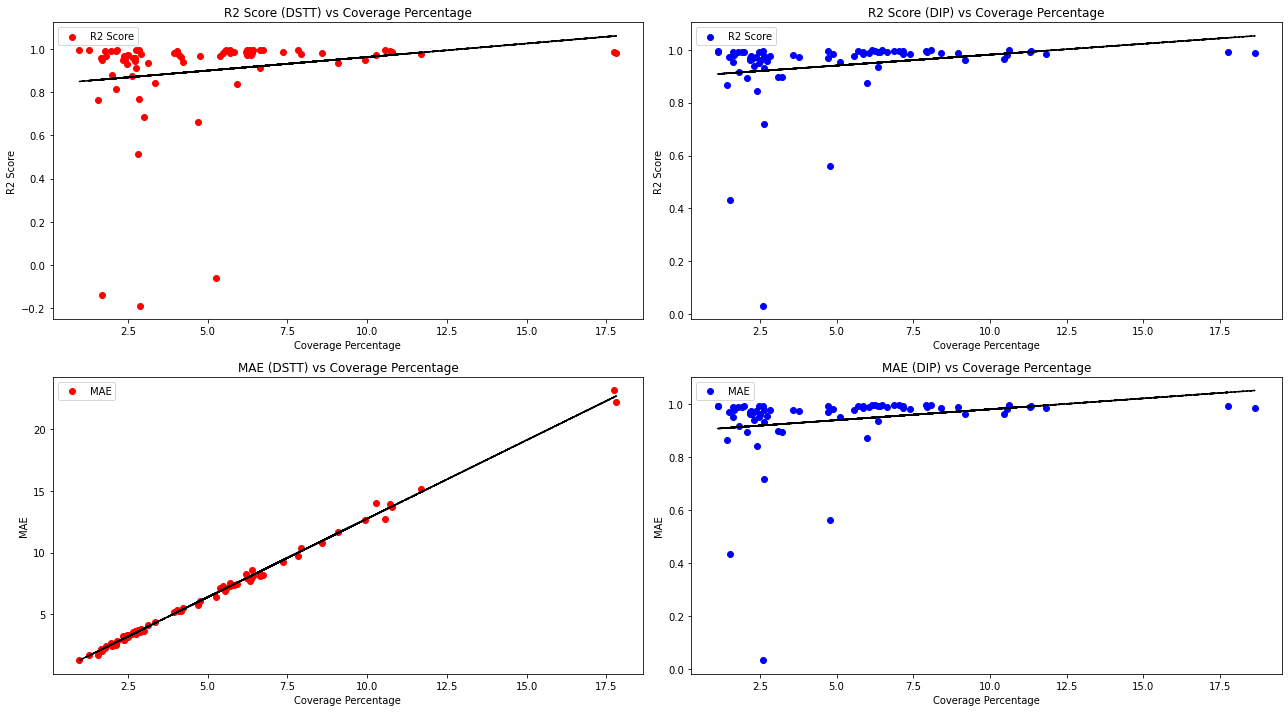

In [6]:
plot_correlation(DSTT_list_coverage, DIP_list_coverage, variance_scores_DSTT, variance_scores_DIP,'Variance')
plot_correlation_r2mae(DSTT_list_coverage, DIP_list_coverage, r2_scores_DSTT, r2_scores_DIP, mae_scores_DSTT, r2_scores_DIP)